In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone
from pathlib import Path

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

RANDOM_STATE = 123

warnings.filterwarnings("ignore")  
sns.set(style="whitegrid")
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")
np.random.seed(RANDOM_STATE)

In [2]:
df = pd.read_csv("1. Insurance.csv")

print("Shape:", df.shape)
display(df.head())

print("\nMissing values per column:")
display(df.isna().sum())

print("\nDtypes:")
display(df.dtypes)


Shape: (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,"16,884.924"
1,18,male,33.770,1,no,southeast,"1,725.552"
2,28,male,33.000,3,no,southeast,"4,449.462"
3,33,male,22.705,0,no,northwest,"21,984.471"
4,32,male,28.880,0,no,northwest,"3,866.855"



Missing values per column:


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


Dtypes:


age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [3]:
info_df = pd.DataFrame({
    "Column": df.columns,
    "Dtype": df.dtypes.astype(str).values,
    "Non-Null": df.notna().sum().values,
    "Missing": df.isna().sum().values,
})

info_df["Missing_%"] = (info_df["Missing"] / len(df) * 100).round(2)
info_df = info_df.sort_values("Missing", ascending=False).reset_index(drop=True)

display(info_df)

display(df.describe().T.round(3))

display(df.describe(include="object").T)

,Column,Dtype,Non-Null,Missing,Missing_%
0,age,int64,1338,0,0.000
1,sex,object,1338,0,0.000
2,bmi,float64,1338,0,0.000
3,children,int64,1338,0,0.000
4,smoker,object,1338,0,0.000
5,region,object,1338,0,0.000
6,charges,float64,1338,0,0.000


,count,mean,std,min,25%,50%,75%,max
age,"1,338.000",39.207,14.050,18.000,27.000,39.000,51.000,64.000
bmi,"1,338.000",30.663,6.098,15.960,26.296,30.400,34.694,53.130
children,"1,338.000",1.095,1.205,0.000,0.000,1.000,2.000,5.000
charges,"1,338.000","13,270.422","12,110.011","1,121.874","4,740.287","9,382.033","16,639.913","63,770.428"


,count,unique,top,freq
sex,1338,2,male,676
smoker,1338,2,no,1064
region,1338,4,southeast,364


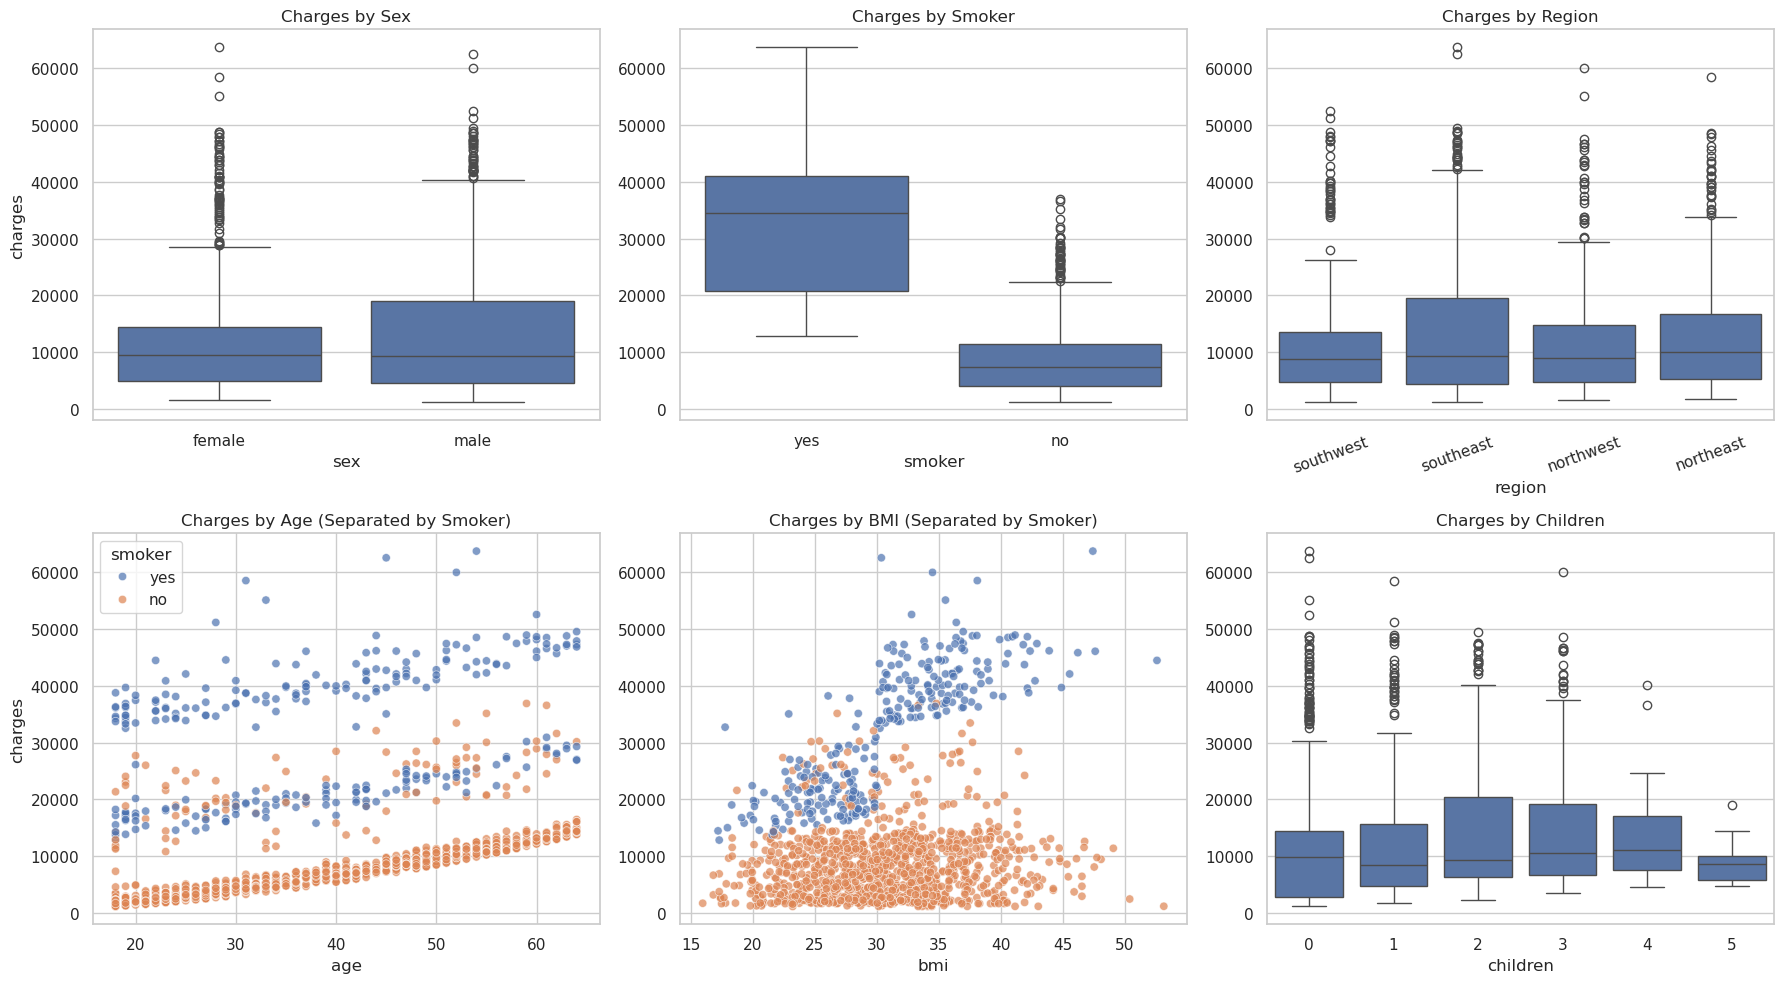

In [4]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

sns.boxplot(data=df, x="sex", y="charges", ax=axes[0, 0])
axes[0, 0].set_title("Charges by Sex")

sns.boxplot(data=df, x="smoker", y="charges", ax=axes[0, 1])
axes[0, 1].set_title("Charges by Smoker")

sns.boxplot(data=df, x="region", y="charges", ax=axes[0, 2])
axes[0, 2].set_title("Charges by Region")
axes[0, 2].tick_params(axis="x", rotation=20)

sns.scatterplot(data=df, x="age", y="charges", hue="smoker", alpha=0.7, ax=axes[1, 0])
axes[1, 0].set_title("Charges by Age (Separated by Smoker)")
axes[1, 0].legend(title="smoker", loc="upper left")

sns.scatterplot(data=df, x="bmi", y="charges", hue="smoker", alpha=0.7, ax=axes[1, 1])
axes[1, 1].set_title("Charges by BMI (Separated by Smoker)")
axes[1, 1].get_legend().remove()  

sns.boxplot(data=df, x="children", y="charges", ax=axes[1, 2])
axes[1, 2].set_title("Charges by Children")

for ax in axes.ravel():
    ax.set_xlabel(ax.get_xlabel())
    ax.set_ylabel("charges" if ax in [axes[0,0], axes[1,0]] else "")

plt.tight_layout()
plt.show()


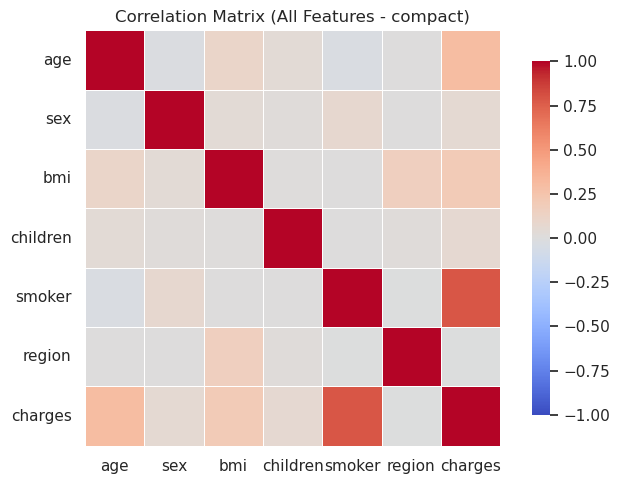

In [5]:
cols = ["age", "sex", "bmi", "children", "smoker", "region", "charges"]
d = df[cols].copy()

d["sex"]    = d["sex"].map({"female": 0, "male": 1})
d["smoker"] = d["smoker"].map({"no": 0, "yes": 1})
d["region"] = d["region"].astype("category").cat.codes

corr = d.corr()

plt.figure(figsize=(7,5))
sns.heatmap(
    corr,
    annot=False,           
    vmin=-1, vmax=1, center=0,
    cmap="coolwarm",
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.85}
)
plt.title("Correlation Matrix (All Features - compact)")
plt.xticks(rotation=0); plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


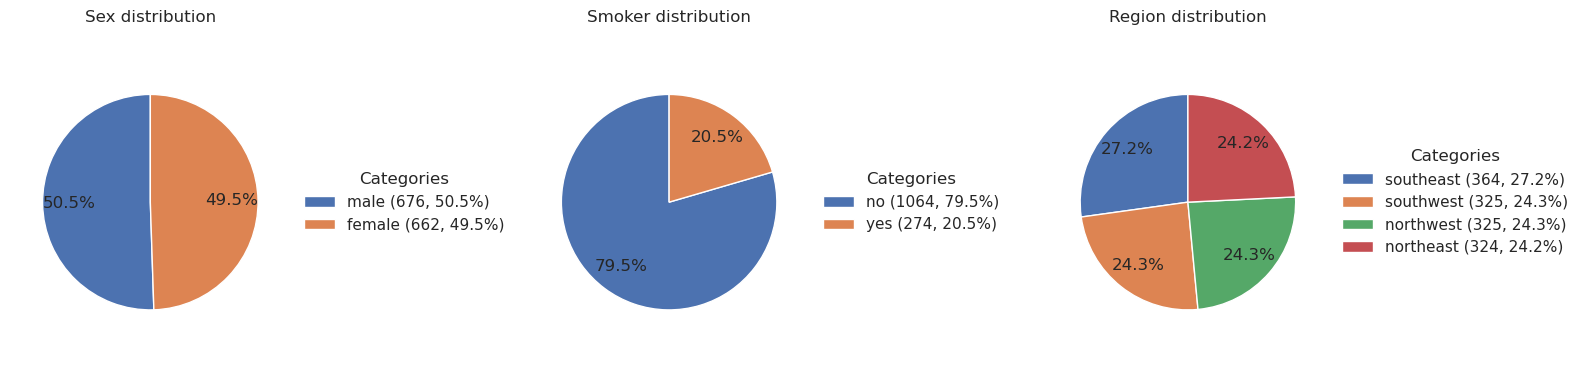

In [6]:
def pie_legend(ax, s, title):
    vc = s.value_counts()
    labels = [f"{k} ({v}, {v/len(s)*100:.1f}%)" for k, v in vc.items()]
    wedges, *_ = ax.pie(vc.values, startangle=90, autopct="%1.1f%%", pctdistance=0.75)
    ax.set_title(title)
    ax.axis("equal")
    ax.legend(wedges, labels, title="Categories", loc="center left",
              bbox_to_anchor=(1.0, 0.5), frameon=False)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
pie_legend(axes[0], df["sex"], "Sex distribution")
pie_legend(axes[1], df["smoker"], "Smoker distribution")
pie_legend(axes[2], df["region"], "Region distribution")
plt.tight_layout()
plt.show()


In [7]:
numeric_features = ["age", "bmi", "children"]
categorical_features = ["sex", "smoker", "region"]
target_column = "charges"

display(pd.DataFrame({
    "Item": ["Numeric features", "Categorical features", "Target"],
    "Value": [", ".join(numeric_features), ", ".join(categorical_features), target_column]
}))

rows = []
n = len(df)

for col in categorical_features:
    vc = df[col].value_counts(dropna=False)
    for k, v in vc.items():
        rows.append({
            "Feature": col,
            "Category": k,
            "Count": int(v),
            "Percent": round(v / n * 100, 1)
        })

counts_df = pd.DataFrame(rows).sort_values(["Feature", "Count"], ascending=[True, False])
display(counts_df)


,Item,Value
0,Numeric features,"age, bmi, children"
1,Categorical features,"sex, smoker, region"
2,Target,charges


,Feature,Category,Count,Percent
4,region,southeast,364,27.200
5,region,southwest,325,24.300
6,region,northwest,325,24.300
7,region,northeast,324,24.200
0,sex,male,676,50.500
1,sex,female,662,49.500
2,smoker,no,1064,79.500
3,smoker,yes,274,20.500


In [8]:
X = df.drop(columns=[target_column]).copy()
y = df[target_column].copy()

x_miss = int(X.isna().sum().sum())
y_miss = int(y.isna().sum())

print(f"X: {X.shape} | y: {y.shape} | y dtype: {y.dtype}")
if x_miss or y_miss:
    print(f"Missing -> X: {x_miss}, y: {y_miss}")

display(X.head())
display(y.head().to_frame(name=target_column))  

X: (1338, 6) | y: (1338,) | y dtype: float64


,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest


,charges
0,"16,884.924"
1,"1,725.552"
2,"4,449.462"
3,"21,984.471"
4,"3,866.855"


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE,
    stratify=X["smoker"] if "smoker" in X.columns else None
)
print(f"Train: X={X_train.shape}, y={y_train.shape}")
print(f"Test : X={X_test.shape}, y={y_test.shape}")

Train: X=(1070, 6), y=(1070,)
Test : X=(268, 6), y=(268,)


In [10]:
def evaluate_regression_model(y_true, y_pred, eps=1e-8):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    return {"R2": r2, "MAE": mae, "RMSE": rmse, "MSE": mse}

In [11]:
preprocessor_linear = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features),
    ],
    remainder="drop"
)

preprocessor_tree = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(drop=None, handle_unknown="ignore"), categorical_features),
    ],
    remainder="drop"
)

display(preprocessor_linear)
display(preprocessor_tree)

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,categories,'auto'
,drop,None
,sparse_output,True


In [12]:
def make_model(model, kind="linear"):
    """
    kind:
      - "linear": for LinearRegression / KNN (scaled + drop first)
      - "tree"  : for DecisionTree / RandomForest (no scaling + keep all categories)
    """
    if kind == "linear":
        prep = preprocessor_linear
    elif kind == "tree":
        prep = preprocessor_tree
    else:
        raise ValueError("kind must be 'linear' or 'tree'")

    return Pipeline(steps=[
        ("preprocess", prep),
        ("regressor", model)
    ])


In [13]:
lin_model = make_model(LinearRegression(), kind="linear")
lin_model

,steps,"[('preprocess', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [14]:
base_models = {
    "LinearRegression": (LinearRegression(), "linear"),
    "KNN": (KNeighborsRegressor(), "linear"),
    "DecisionTree": (DecisionTreeRegressor(random_state=RANDOM_STATE), "tree"),
    "RandomForest": (RandomForestRegressor(random_state=RANDOM_STATE), "tree"),
}

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

rows = []
for name, (model, kind) in base_models.items():
    prep = preprocessor_linear if kind == "linear" else preprocessor_tree

    pipe = Pipeline(steps=[
        ("preprocess", prep),
        ("model", model)
    ])

    scores = cross_validate(
        pipe, X_train, y_train,
        cv=cv,
        scoring={"r2": "r2", "mae": "neg_mean_absolute_error"},
        n_jobs=-1
    )

    rows.append({
        "Model": name,
        "CV_R2_mean": scores["test_r2"].mean(),
        "CV_R2_std":  scores["test_r2"].std(),
        "CV_MAE_mean": -scores["test_mae"].mean(),
        "CV_MAE_std":  scores["test_mae"].std(),
    })

cv_df = (pd.DataFrame(rows)
         .set_index("Model")
         .round(4)
         .sort_values("CV_R2_mean", ascending=False))

display(cv_df)

,CV_R2_mean,CV_R2_std,CV_MAE_mean,CV_MAE_std
Model,,,,
RandomForest,0.844,0.012,"2,571.031",236.703
LinearRegression,0.750,0.033,"4,048.234",252.009
DecisionTree,0.666,0.060,"3,309.395",316.383
KNN,0.660,0.037,"4,043.101",330.414


In [15]:
best_name = "RandomForest"
print("Best by CV:", best_name)

best_model = Pipeline(steps=[
    ("preprocess", preprocessor_tree),
    ("model", RandomForestRegressor(
        random_state=RANDOM_STATE,
        n_estimators=300,
        n_jobs=-1,
        max_depth=12,
        min_samples_leaf=5
    ))
])

best_model.fit(X_train, y_train)

train_metrics = evaluate_regression_model(y_train, best_model.predict(X_train))
test_metrics  = evaluate_regression_model(y_test,  best_model.predict(X_test))

summary = pd.DataFrame([train_metrics, test_metrics], index=["Train", "Test"]).round(3)
summary["R2_gap"] = (summary.loc["Train","R2"] - summary.loc["Test","R2"]).round(3)

display(summary)


Best by CV: RandomForest


,R2,MAE,RMSE,MSE,R2_gap
Train,0.918,"1,828.044","3,447.702","11,886,651.283",0.098
Test,0.820,"2,750.660","5,234.623","27,401,277.534",0.098


In [16]:
def overfitting_summary(models, X_train, y_train, X_test, y_test,
                       preprocessor_linear, preprocessor_tree):
    rows = []
    for name, (estimator, kind) in models.items():
        prep = preprocessor_linear if kind == "linear" else preprocessor_tree

        pipe = Pipeline([
            ("preprocess", prep),
            ("model", clone(estimator))
        ])
        pipe.fit(X_train, y_train)

        tr = evaluate_regression_model(y_train, pipe.predict(X_train))
        te = evaluate_regression_model(y_test,  pipe.predict(X_test))

        rows.append({
            "Model": name,
            "Train_R2": tr["R2"],
            "Test_R2": te["R2"],
            "R2_gap": tr["R2"] - te["R2"],
            "Train_RMSE": tr["RMSE"],
            "Test_RMSE": te["RMSE"],
        })

    return (pd.DataFrame(rows)
              .set_index("Model")
              .sort_values("R2_gap", ascending=False))


In [17]:
models = base_models

overfit_df = overfitting_summary(
    models, X_train, y_train, X_test, y_test,
    preprocessor_linear, preprocessor_tree
)

display(overfit_df.round(4))

,Train_R2,Test_R2,R2_gap,Train_RMSE,Test_RMSE
Model,,,,,
DecisionTree,0.998,0.726,0.273,494.206,"6,464.555"
RandomForest,0.979,0.800,0.178,"1,758.137","5,513.162"
KNN,0.815,0.644,0.170,"5,183.334","7,356.965"
LinearRegression,0.763,0.700,0.064,"5,858.187","6,763.828"


In [18]:
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
param_grid_rf = {
    "model__n_estimators": [200, 400],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [1, 2, 4],
}

rf_pipe = Pipeline(steps=[
    ("preprocess", preprocessor_tree),   
    ("model", RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])

rf_grid = GridSearchCV(
    estimator=rf_pipe,
    param_grid=param_grid_rf,
    cv=kf,
    scoring="r2",
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)

print("Best params for RF:", rf_grid.best_params_)
print("Best CV R2 for RF:", round(rf_grid.best_score_, 4))

y_pred_rf_tuned = rf_grid.predict(X_test)
metrics_rf_tuned = evaluate_regression_model(y_test, y_pred_rf_tuned)
display(pd.Series(metrics_rf_tuned).round(3))


Best params for RF: {'model__max_depth': 10, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2, 'model__n_estimators': 400}
Best CV R2 for RF: 0.8597


R2              0.820
MAE         2,744.525
RMSE        5,241.114
MSE    27,469,278.797
dtype: float64

In [19]:
print("Baseline RF (default) Test:")
display(pd.Series(evaluate_regression_model(y_test, best_model.predict(X_test))).round(3))

print("Tuned RF Test:")
display(pd.Series(metrics_rf_tuned).round(3))

Baseline RF (default) Test:


R2              0.820
MAE         2,750.660
RMSE        5,234.623
MSE    27,401,277.534
dtype: float64

Tuned RF Test:


R2              0.820
MAE         2,744.525
RMSE        5,241.114
MSE    27,469,278.797
dtype: float64

In [20]:
y_pred_best = best_model.predict(X_test)
residuals = y_test - y_pred_best

sample_df = pd.DataFrame({
    "y_test": y_test,
    "y_pred": y_pred_best,
    "residual": residuals,
    "abs_error": residuals.abs()
}).round(3)

display(sample_df.head(10))                        
display(sample_df.sort_values("abs_error", ascending=False).head(10))  

,y_test,y_pred,residual,abs_error
660,"6,435.624","7,543.775","-1,108.151","1,108.151"
270,"1,719.436","2,791.920","-1,072.483","1,072.483"
731,"10,065.413","12,259.297","-2,193.884","2,193.884"
953,"38,998.546","42,729.365","-3,730.819","3,730.819"
959,"28,468.919","9,097.026","19,371.893","19,371.893"
1262,"6,770.192","6,891.351",-121.159,121.159
546,"3,268.847","6,584.166","-3,315.319","3,315.319"
84,"39,836.519","39,425.698",410.821,410.821
1021,"35,595.590","34,771.858",823.732,823.732
184,"7,731.427","8,498.766",-767.339,767.339


,y_test,y_pred,residual,abs_error
1206,"36,910.608","14,414.870","22,495.738","22,495.738"
806,"28,476.735","6,807.698","21,669.037","21,669.037"
140,"27,375.905","6,570.474","20,805.430","20,805.430"
1012,"36,580.282","16,744.984","19,835.298","19,835.298"
1019,"26,018.951","6,411.539","19,607.411","19,607.411"
599,"33,471.972","14,068.369","19,403.603","19,403.603"
959,"28,468.919","9,097.026","19,371.893","19,371.893"
1027,"21,595.382","3,699.573","17,895.809","17,895.809"
3,"21,984.471","4,782.373","17,202.098","17,202.098"
1211,"23,563.016","6,845.435","16,717.581","16,717.581"


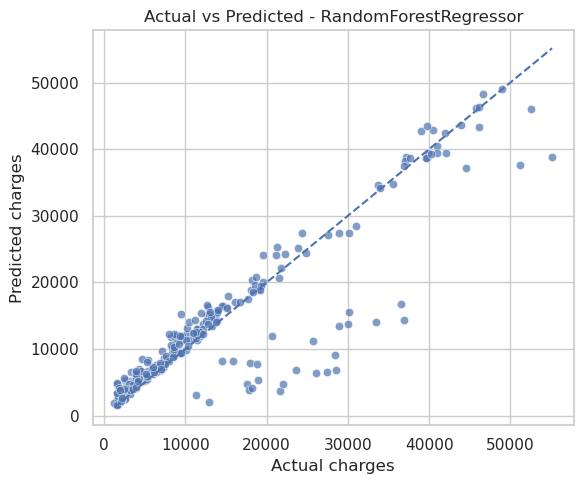

In [21]:
plt.figure(figsize=(6, 5))
sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.7)

m = min(y_test.min(), y_pred_best.min())
M = max(y_test.max(), y_pred_best.max())
plt.plot([m, M], [m, M], linestyle="--")

plt.xlabel("Actual charges")
plt.ylabel("Predicted charges")
best_model_name = type(best_model.named_steps["model"]).__name__
plt.title(f"Actual vs Predicted - {best_model_name}")
plt.tight_layout()
plt.show()

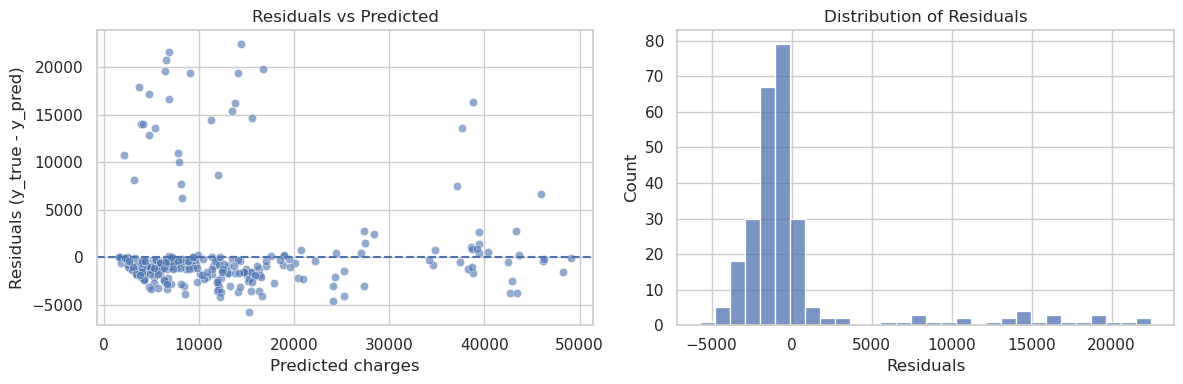

In [22]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_pred_best, y=residuals, alpha=0.6)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted charges")
plt.ylabel("Residuals (y_true - y_pred)")
plt.title("Residuals vs Predicted")

plt.subplot(1, 2, 2)
sns.histplot(residuals, bins=30) 
plt.xlabel("Residuals")
plt.title("Distribution of Residuals")

plt.tight_layout()
plt.show()

In [23]:
base_models = {
    "Linear Regression (base)": (LinearRegression(), "linear"),
    "KNN (base)": (KNeighborsRegressor(), "linear"),
    "Decision Tree (base)": (DecisionTreeRegressor(random_state=RANDOM_STATE), "tree"),
    "RandomForest (base)": (RandomForestRegressor(random_state=RANDOM_STATE), "tree"),
}

baseline_rows = []
for name, (est, kind) in base_models.items():
    prep = preprocessor_linear if kind == "linear" else preprocessor_tree
    pipe = Pipeline([("preprocess", prep), ("model", clone(est))])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    m = evaluate_regression_model(y_test, y_pred)  
    m["Model"] = name
    baseline_rows.append(m)

baseline_df = (
    pd.DataFrame(baseline_rows)
      .set_index("Model")[["R2", "MAE", "RMSE", "MSE"]]
      .round(3)
)

tuned_df = pd.DataFrame([metrics_rf_tuned], index=["RandomForest (After Tuning)"])[["R2", "MAE", "RMSE", "MSE"]].round(3)

final_df = pd.concat([baseline_df, tuned_df], axis=0)
display(final_df)


,R2,MAE,RMSE,MSE
Linear Regression (base),0.700,"4,506.381","6,763.828","45,749,362.695"
KNN (base),0.645,"4,215.028","7,356.965","54,124,930.031"
Decision Tree (base),0.726,"2,958.828","6,464.555","41,790,469.588"
RandomForest (base),0.800,"3,012.052","5,513.162","30,394,958.754"
RandomForest (After Tuning),0.820,"2,744.525","5,241.114","27,469,278.797"
